# Time-based operations

In this notebook, we show how to work with operations along the time axis. The sample files used here are
small enough so it's not mandatory to use a DASK cluster but compute cells can typically take 30s/1min. 
Feel free to add a dask cluster using the templates.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import subprocess as sp

In [3]:
import xarray as xr

Open the dataset and inspect it:

In [4]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1}, engine='pydap')

In [5]:
ds

<xarray.Dataset>
Dimensions:       (nv: 2, time: 60, xh: 720, xq: 720, yh: 576, yq: 576, z_i: 36, z_l: 35)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq            (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 59.0 59.5 60.0
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq            (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time          (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
Data variables:
    Coriolis      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    deptho        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxCu          (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxCv          (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxt           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyCu          (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyCv          (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyt           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_c      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_u      (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_v      (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_c      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_u      (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_v      (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    hfgeou        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    sftof         (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    thkcello      (z_l, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    wet           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_c         (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_u         (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_v         (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    so            (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    time_bnds     (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    thetao        (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    umo           (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    uo            (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vmo           (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vo            (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    volcello

## 1. Computing climatologies for SST

### 1.1 Annual climatology

We have a 5 years monthly dataset that we can use to compute a climatology:

In [6]:
climato_sst = ds['thetao'].sel(z_l=2.5).mean(dim='time')

In [7]:
climato_sst

<xarray.DataArray 'thetao' (yh: 576, xh: 720)>
dask.array<mean_agg-aggregate, shape=(576, 720), dtype=float32, chunksize=(576, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
    z_l      float64 2.5

The result is instaneous because none of the computation actually happened. This is called lazy evaluation, xarray only returns the structure of the resulting data array. Calling plot will explicitly trigger compute:

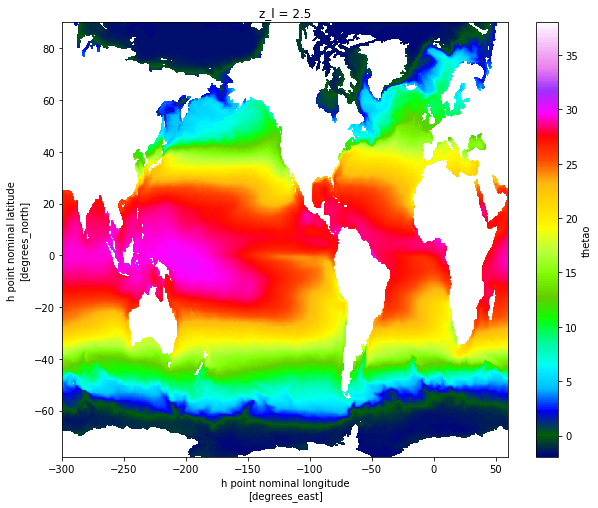

In [8]:
climato_sst.plot(figsize=[10,8], vmin=-2, vmax=38, cmap='gist_ncar')

### 1.2 Monthly climatology

Using groupby, we can group data by month and then average over the years, resulting in a monthly climatology:

In [9]:
sst = ds['thetao'].sel(z_l=2.5)
monthly_clim_sst = sst.groupby(sst['time'].dt.month).mean(dim='time')

In [10]:
monthly_clim_sst

<xarray.DataArray 'thetao' (month: 12, yh: 576, xh: 720)>
dask.array<stack, shape=(12, 576, 720), dtype=float32, chunksize=(1, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
    z_l      float64 2.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Let's look at the climatological seasonal cycle in zonal average. 

NB: For an irregular grid such as this one, **the x-mean is not a correct zonal mean in the arctic**. See tutorial on spatial averages for correct computation.

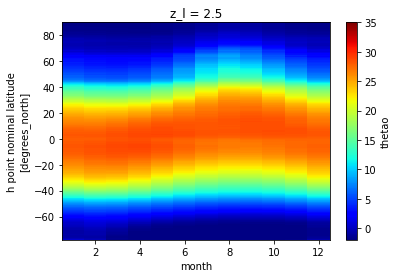

In [11]:
monthly_clim_sst.mean(dim='xh').plot(vmin=-2, vmax=35, cmap='jet', x='month')

### 1.3 Anomaly to seasonal cycle

In [12]:
anom = sst.groupby(sst['time'].dt.month) - monthly_clim_sst

In [13]:
anom

<xarray.DataArray 'thetao' (time: 60, yh: 576, xh: 720)>
dask.array<getitem, shape=(60, 576, 720), dtype=float32, chunksize=(1, 576, 720), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 2.5
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * time     (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

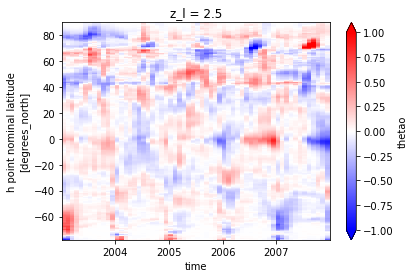

In [14]:
anom.mean(dim='xh').plot(vmin=-1, vmax=1, cmap='bwr', x='time')

It's a bit noisy but We can make it annual with a new groupby:

In [15]:
yearly_anom = anom.groupby(anom['time'].dt.year).mean(dim='time')

In [16]:
yearly_anom

<xarray.DataArray 'thetao' (year: 5, yh: 576, xh: 720)>
dask.array<stack, shape=(5, 576, 720), dtype=float32, chunksize=(1, 576, 720), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 2.5
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * year     (year) int64 2003 2004 2005 2006 2007

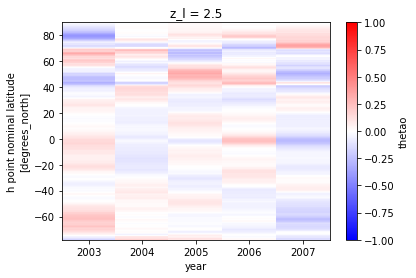

In [17]:
yearly_anom.mean(dim='xh').plot(vmin=-1, vmax=1, cmap='bwr', x='year')

## 2. Selecting based on dates

Dates in the dataset are interpreted as time objects, which makes it easy to select a range of dates once you are familiar with how to write the query. 

In [18]:
ds['time']

<xarray.DataArray 'time' (time: 60)>
array([cftime.DatetimeNoLeap(2003, 1, 16, 12, 0, 0, 0, 2, 16),
       cftime.DatetimeNoLeap(2003, 2, 15, 0, 0, 0, 0, 4, 46),
       cftime.DatetimeNoLeap(2003, 3, 16, 12, 0, 0, 0, 5, 75),
       cftime.DatetimeNoLeap(2003, 4, 16, 0, 0, 0, 0, 1, 106),
       cftime.DatetimeNoLeap(2003, 5, 16, 12, 0, 0, 0, 3, 136),
       cftime.DatetimeNoLeap(2003, 6, 16, 0, 0, 0, 0, 6, 167),
       cftime.DatetimeNoLeap(2003, 7, 16, 12, 0, 0, 0, 1, 197),
       cftime.DatetimeNoLeap(2003, 8, 16, 12, 0, 0, 0, 4, 228),
       cftime.DatetimeNoLeap(2003, 9, 16, 0, 0, 0, 0, 0, 259),
       cftime.DatetimeNoLeap(2003, 10, 16, 12, 0, 0, 0, 2, 289),
       cftime.DatetimeNoLeap(2003, 11, 16, 0, 0, 0, 0, 5, 320),
       cftime.DatetimeNoLeap(2003, 12, 16, 12, 0, 0, 0, 0, 350),
       cftime.DatetimeNoLeap(2004, 1, 16, 12, 0, 0, 0, 3, 16),
       cftime.DatetimeNoLeap(2004, 2, 15, 0, 0, 0, 0, 5, 46),
       cftime.DatetimeNoLeap(2004, 3, 16, 12, 0, 0, 0, 6, 75),
       cftime.DatetimeNoLeap(2004, 4, 16, 0, 0, 0, 0, 2, 106),
       cftime.DatetimeNoLeap(2004, 5, 16, 12, 0, 0, 0, 4, 136),
       cftime.DatetimeNoLeap(2004, 6, 16, 0, 0, 0, 0, 0, 167),
       cftime.DatetimeNoLeap(2004, 7, 16, 12, 0, 0, 0, 2, 197),
       cftime.DatetimeNoLeap(2004, 8, 16, 12, 0, 0, 0, 5, 228),
       cftime.DatetimeNoLeap(2004, 9, 16, 0, 0, 0, 0, 1, 259),
       cftime.DatetimeNoLeap(2004, 10, 16, 12, 0, 0, 0, 3, 289),
       cftime.DatetimeNoLeap(2004, 11, 16, 0, 0, 0, 0, 6, 320),
       cftime.DatetimeNoLeap(2004, 12, 16, 12, 0, 0, 0, 1, 350),
       cftime.DatetimeNoLeap(2005, 1, 16, 12, 0, 0, 0, 4, 16),
       cftime.DatetimeNoLeap(2005, 2, 15, 0, 0, 0, 0, 6, 46),
       cftime.DatetimeNoLeap(2005, 3, 16, 12, 0, 0, 0, 0, 75),
       cftime.DatetimeNoLeap(2005, 4, 16, 0, 0, 0, 0, 3, 106),
       cftime.DatetimeNoLeap(2005, 5, 16, 12, 0, 0, 0, 5, 136),
       cftime.DatetimeNoLeap(2005, 6, 16, 0, 0, 0, 0, 1, 167),
       cftime.DatetimeNoLeap(2005, 7, 16, 12, 0, 0, 0, 3, 197),
       cftime.DatetimeNoLeap(2005, 8, 16, 12, 0, 0, 0, 6, 228),
       cftime.DatetimeNoLeap(2005, 9, 16, 0, 0, 0, 0, 2, 259),
       cftime.DatetimeNoLeap(2005, 10, 16, 12, 0, 0, 0, 4, 289),
       cftime.DatetimeNoLeap(2005, 11, 16, 0, 0, 0, 0, 0, 320),
       cftime.DatetimeNoLeap(2005, 12, 16, 12, 0, 0, 0, 2, 350),
       cftime.DatetimeNoLeap(2006, 1, 16, 12, 0, 0, 0, 5, 16),
       cftime.DatetimeNoLeap(2006, 2, 15, 0, 0, 0, 0, 0, 46),
       cftime.DatetimeNoLeap(2006, 3, 16, 12, 0, 0, 0, 1, 75),
       cftime.DatetimeNoLeap(2006, 4, 16, 0, 0, 0, 0, 4, 106),
       cftime.DatetimeNoLeap(2006, 5, 16, 12, 0, 0, 0, 6, 136),
       cftime.DatetimeNoLeap(2006, 6, 16, 0, 0, 0, 0, 2, 167),
       cftime.DatetimeNoLeap(2006, 7, 16, 12, 0, 0, 0, 4, 197),
       cftime.DatetimeNoLeap(2006, 8, 16, 12, 0, 0, 0, 0, 228),
       cftime.DatetimeNoLeap(2006, 9, 16, 0, 0, 0, 0, 3, 259),
       cftime.DatetimeNoLeap(2006, 10, 16, 12, 0, 0, 0, 5, 289),
       cftime.DatetimeNoLeap(2006, 11, 16, 0, 0, 0, 0, 1, 320),
       cftime.DatetimeNoLeap(2006, 12, 16, 12, 0, 0, 0, 3, 350),
       cftime.DatetimeNoLeap(2007, 1, 16, 12, 0, 0, 0, 6, 16),
       cftime.DatetimeNoLeap(2007, 2, 15, 0, 0, 0, 0, 1, 46),
       cftime.DatetimeNoLeap(2007, 3, 16, 12, 0, 0, 0, 2, 75),
       cftime.DatetimeNoLeap(2007, 4, 16, 0, 0, 0, 0, 5, 106),
       cftime.DatetimeNoLeap(2007, 5, 16, 12, 0, 0, 0, 0, 136),
       cftime.DatetimeNoLeap(2007, 6, 16, 0, 0, 0, 0, 3, 167),
       cftime.DatetimeNoLeap(2007, 7, 16, 12, 0, 0, 0, 5, 197),
       cftime.DatetimeNoLeap(2007, 8, 16, 12, 0, 0, 0, 1, 228),
       cftime.DatetimeNoLeap(2007, 9, 16, 0, 0, 0, 0, 4, 259),
       cftime.DatetimeNoLeap(2007, 10, 16, 12, 0, 0, 0, 6, 289),
       cftime.DatetimeNoLeap(2007, 11, 16, 0, 0, 0, 0, 2, 320),
       cftime.DatetimeNoLeap(2007, 12, 16, 12, 0, 0, 0, 4, 350)], dtype=object)
Coordinates:
  * time     (time) object 2003-01-16 12:00:00 ... 2007-12-16 12:00:00
Attributes:
    long_name:       time
    cartesi

For example, selecting a range of years (think time **slice**):

In [19]:
my_selection = ds.sel(time=slice('2003', '2005'))

In [20]:
my_selection

<xarray.Dataset>
Dimensions:       (nv: 2, time: 36, xh: 720, xq: 720, yh: 576, yq: 576, z_i: 36, z_l: 35)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq            (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 59.0 59.5 60.0
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq            (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time          (time) object 2003-01-16 12:00:00 ... 2005-12-16 12:00:00
Data variables:
    Coriolis      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    deptho        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxCu          (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxCv          (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxt           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyCu          (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyCv          (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyt           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_c      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_u      (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_v      (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_c      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_u      (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_v      (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    hfgeou        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    sftof         (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    thkcello      (z_l, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    wet           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_c         (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_u         (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_v         (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    so            (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    time_bnds     (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    thetao        (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    umo           (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    uo            (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vmo           (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vo            (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    volcello

Or just a few months:

In [21]:
my_selection2 = ds.sel(time=slice('2004-04', '2005-07'))

In [22]:
my_selection2

<xarray.Dataset>
Dimensions:       (nv: 2, time: 16, xh: 720, xq: 720, yh: 576, yq: 576, z_i: 36, z_l: 35)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq            (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 59.0 59.5 60.0
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq            (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * time          (time) object 2004-04-16 00:00:00 ... 2005-07-16 12:00:00
Data variables:
    Coriolis      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello     (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    deptho        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxCu          (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxCv          (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dxt           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyCu          (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyCv          (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    dyt           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_c      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_u      (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolat_v      (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_c      (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_u      (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon_v      (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    hfgeou        (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    sftof         (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    thkcello      (z_l, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    wet           (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_c         (yq, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_u         (yh, xq) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    wet_v         (yq, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    so            (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    time_bnds     (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    thetao        (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    umo           (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    uo            (time, z_l, yh, xq) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vmo           (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    vo            (time, z_l, yq, xh) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
    volcello